### Data Loader


In [ ]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import numpy as n
from cityscapesscripts.helpers.labels import id2label

class CityscapesDataset(Dataset):
    def __init__(self, image_folder, label_folder, transform=None, label_transform=None):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.transform = transform
        self.label_transform = label_transform

        # Sort to keep image-label pairing aligned
        self.image_paths = sorted([os.path.join(image_folder, x) for x in os.listdir(image_folder) if x.endswith('.png')])
        self.label_paths = sorted([os.path.join(label_folder, x) for x in os.listdir(label_folder) if x.endswith('gtFine_labelIds.png')])

        # Optional check
        assert len(self.image_paths) == len(self.label_paths), "Mismatch between images and labels"

    def __len__(self):
        return len(self.image_paths) 

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        image = Image.open(image_path).convert('RGB')
        label = Image.open(label_path)
        label = np.array(label)               
        label = self.remap_to_train_id(label) 
        label = Image.fromarray(label.astype(np.uint8)) 

        if self.transform:
            image = self.transform(image)

        if self.label_transform:
            label = self.label_transform(label)

        return image, label

    # def remap_to_train_id(self, label_np):
    #     label_train = np.full_like(label_np, 255)
    #     for id, label in id2label.items():
    #         label_train[label_np == id] = label.trainId
    #     return label_train
    # def remap_to_train_id(self, label_np):
    #     label_train = np.full_like(label_np, 255)  # Default all pixels to 255 (ignore)
        


    ## this is a funtion to remap the label id to train id because in cutyscaors dataset there are 34 classses, someof which are not useful 
    ## so by converting them into 19 using Github original repo code of cityscapes dataset
    # cityscapesscripts library
    
    def remap_to_train_id(self, label_np):
        label_train = np.full_like(label_np, 255) 
        
        for id, label in id2label.items():
            if label.trainId != -1:  
                label_train[label_np == id] = label.trainId
        
        label_train[label_train == -1] = 255  

        return label_train


image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

label_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze(0).long())  # [1, H, W] -> [H, W]
])


In [ ]:
from torch.utils.data import DataLoader

train_dataset = CityscapesDataset(
    image_folder='D:/Citscapes dataset/Input/leftImg8bit/train_final',
    label_folder='D:/Citscapes dataset/Output/train_final',
    transform=image_transform,
    label_transform=label_transform
)
val_dataset = CityscapesDataset(
    image_folder='D:/Citscapes dataset/Input/leftImg8bit/val_final',
    label_folder='D:/Citscapes dataset/Output/val_final',
    transform=image_transform,
    label_transform=label_transform
)
test_dataset = CityscapesDataset(
    image_folder='D:/Citscapes dataset/Input/leftImg8bit/test_final',
    label_folder='D:/Citscapes dataset/Output/test_final',
    transform=image_transform,
    label_transform=label_transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


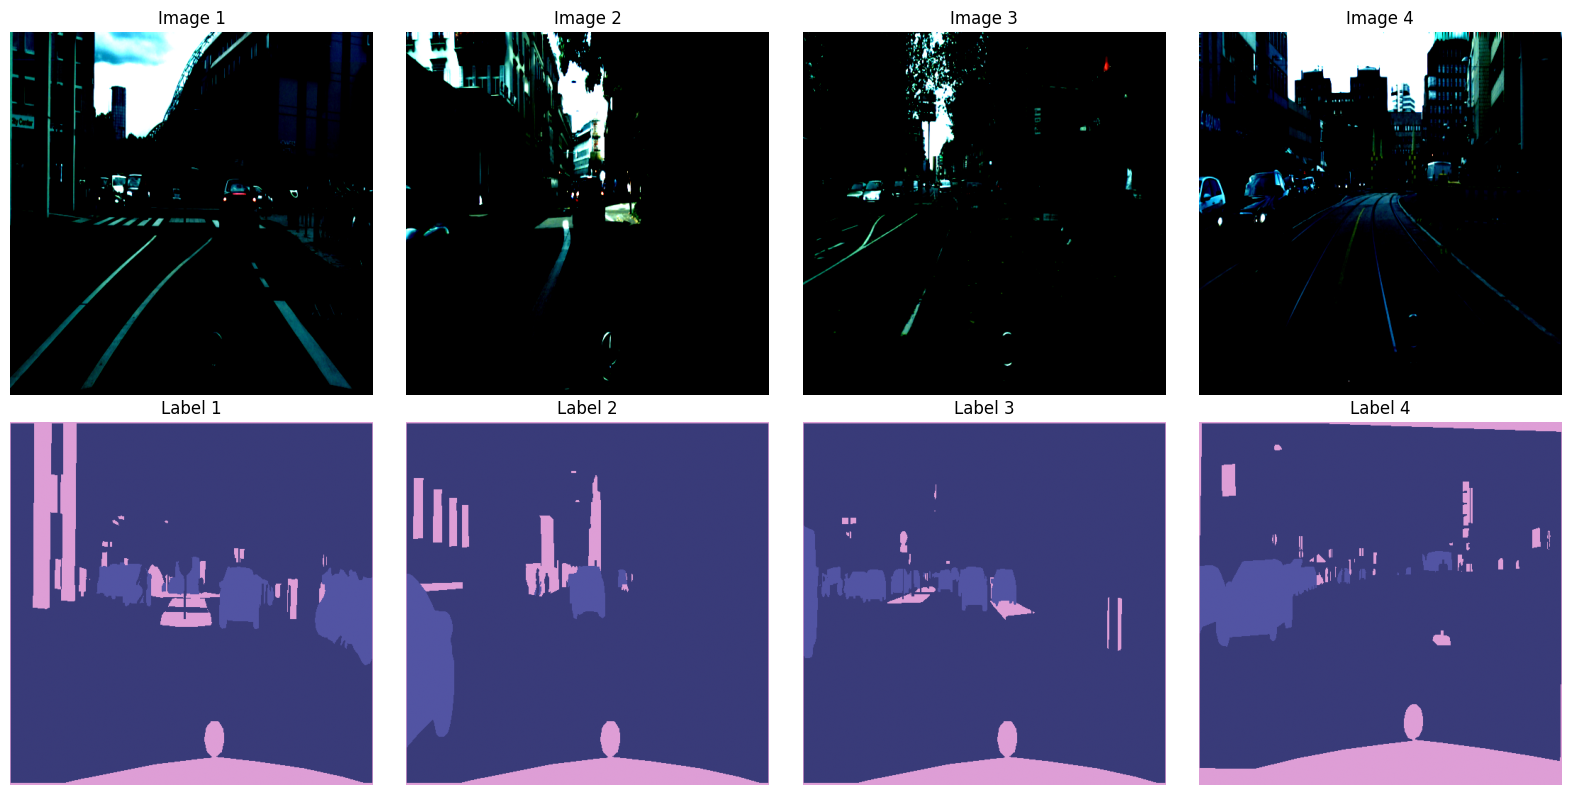

In [4]:
import matplotlib.pyplot as plt

# Fetch the first batch
images, labels = next(iter(dataloader))

# Convert images and labels back to numpy for visualization
images = images.numpy()  # (batch_size, channels, height, width)
labels = labels.numpy()  # (batch_size, height, width)

# Plot the images and corresponding labels
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(4):  # Loop through the batch size (4 in this case)
    # Show image
    axes[0, i].imshow(np.transpose(images[i], (1, 2, 0)))  # Convert from (C, H, W) to (H, W, C)
    axes[0, i].set_title(f"Image {i+1}")
    axes[0, i].axis('off')

    # Show label
    axes[1, i].imshow(labels[i], cmap='tab20b')  # Use a colormap for better visualization
    axes[1, i].set_title(f"Label {i+1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class ASPPModule(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ASPPModule, self).__init__()


        self.atrousBlock1 = nn.Sequential(

            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    
        self.atrousBlock2 = nn.Sequential(

            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=6, dilation=6),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        self.atrousBlock3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=12, dilation=12),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        
        )

        self.atrousBlock4 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=18, dilation=18),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
        self.imagePooling = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        self.output = nn.Sequential(
        nn.Conv2d(out_channels * 5, out_channels, kernel_size=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
        )

    
    def forward(self,x):
        

        x1=self.atrousBlock1(x)
        x2=self.atrousBlock2(x)
        x3=self.atrousBlock3(x)
        x4=self.atrousBlock4 (x)

        img_pool=F.interpolate(self.imagePooling(x), size=x.shape[2:], mode='bilinear', align_corners=False)


        x=torch.cat([x1,x2,x3,x4,img_pool], dim=1)
        return self.output(x)
    



class Decoder(nn.Module):
    def __init__(self, low_channels, out_channels, num_classes):
        super().__init__()

        self.reduce_low = nn.Sequential(
            nn.Conv2d(low_channels, 48, 1),
            nn.BatchNorm2d(48),
            nn.ReLU()
        )

        self.fuse = nn.Sequential(
            nn.Conv2d(48 + out_channels, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.classifier = nn.Conv2d(256, num_classes, 1)

    def forward(self, low_feat, high_feat):
        low_feat = self.reduce_low(low_feat)
        high_feat = F.interpolate(high_feat, size=low_feat.shape[2:], mode='bilinear', align_corners=False)

        x = torch.cat([low_feat, high_feat], dim=1)
        x = self.fuse(x)
        return self.classifier(x)


import torch.nn as nn
import torch
import torchvision.models as models

class MobileNetV2Backbone (nn.Module):
    def __init__(self,low_level_idx=2,high_level_idx=4):
        super().__init__()
        base_model=models.mobilenet_v2(pretrained=True)
        self.low_level_features=base_model.features[:4]
        self.high_level_features=base_model.features[4:]


    def forward (self,x):
        low_feat=self.low_level_features(x)
        high_feat=self.high_level_features(low_feat)

        return low_feat,high_feat
    

import torch.nn as nn
import torch.nn.functional as F
import torch

class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = MobileNetV2Backbone()
        self.aspp = ASPPModule(in_channels=1280, out_channels=256)
        self.decoder = Decoder(low_channels=24, out_channels=256, num_classes=num_classes)

    def forward(self, x):
        input_size=x.shape[2:]
        low, high = self.backbone(x)
        high = self.aspp(high)
        x = self.decoder(low, high)
        # x = F.interpolate(x, size=(x.shape[2]*4, x.shape[3]*4), mode='bilinear', align_corners=False)
        x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=False)

        return x





    

In [17]:
import torch.nn as nn
import torch.optim as optim

device="cpu"
model = DeepLabV3Plus(num_classes=19).to(device)  # Move to GPU if available

criterion = nn.CrossEntropyLoss(ignore_index=255)  # Ignore unlabeled pixels
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


d:\anaconda\envs\transformer\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\envs\transformer\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
from tqdm import tqdm

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    print(f"Train Loss: {epoch_loss:.4f}")


In [20]:
for images, labels in dataloader:
    print(f"Image shape: {images.shape}")   # Should be [B, 3, H, W]
    print(f"Label shape: {labels.shape}")   # Should be [B, H, W]
    print(f"Image dtype: {images.dtype}")   # torch.float32
    print(f"Label dtype: {labels.dtype}")   # torch.int64 (long)
    break  # just check one batch


Image shape: torch.Size([4, 3, 512, 512])
Label shape: torch.Size([4, 512, 512])
Image dtype: torch.float32
Label dtype: torch.int64


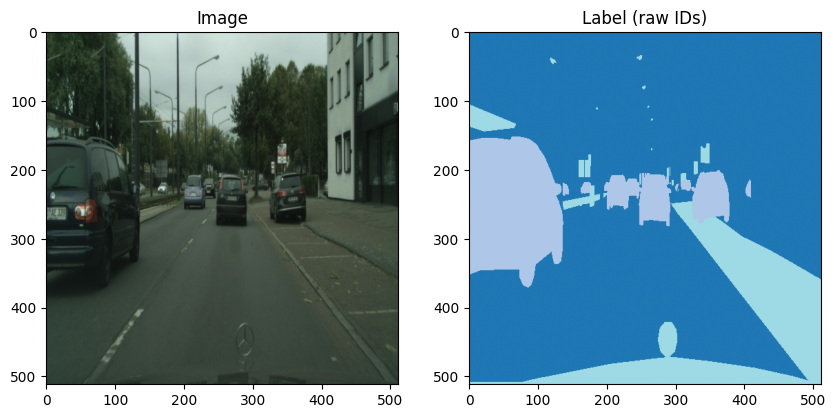

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_pil_image

images, labels = next(iter(dataloader))  # Get one batch

image = images[0].cpu()
label = labels[0].cpu().numpy()

# Denormalize the image for display
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
image_vis = image * std + mean
image_vis = image_vis.clamp(0, 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(to_pil_image(image_vis))

plt.subplot(1, 2, 2)
plt.title("Label (raw IDs)")
plt.imshow(label, cmap='tab20')  # You can use Cityscapes color map if available
plt.show()


In [22]:
unique_classes = torch.unique(labels[0])
print("Unique classes in label:", unique_classes.tolist())


Unique classes in label: [0, 1, 2, 5, 6, 8, 9, 10, 13, 14, 255]


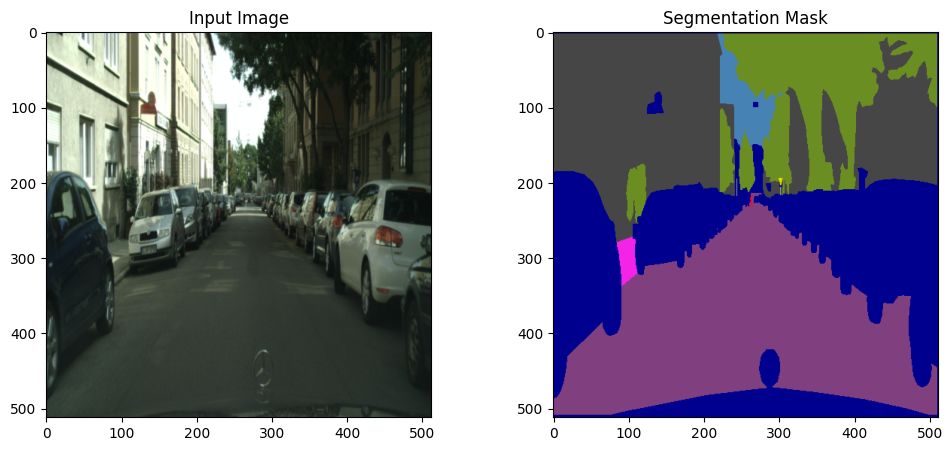

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from cityscapesscripts.helpers.labels import trainId2label

# Create color map for Cityscapes trainIds
color_map = np.zeros((256, 3), dtype=np.uint8)
for train_id, label in trainId2label.items():
    if train_id < 255:
        color_map[train_id] = label.color  # label.color is an (R, G, B) tuple

def decode_segmap(label_mask):
    """
    Takes a [H, W] mask of trainIds and returns an RGB image.
    """
    return color_map[label_mask]

# Assuming image and label come from your dataloader
for image, label in dataloader:
    image_np = image[0].permute(1, 2, 0).numpy()
    image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    image_np = np.clip(image_np, 0, 1)

    label_np = label[0].numpy()
    label_rgb = decode_segmap(label_np)

    # Plot image and label
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Input Image")

    plt.subplot(1, 2, 2)
    plt.imshow(label_rgb)
    plt.title("Segmentation Mask")

    plt.show()
    break  # remove this if you want to loop over more images
